In [2]:
pip install pandas matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = "C:\\Users\\user\\OneDrive\\Documents\\M2 SNS IDS\\HAH913E - Santé activité physique 5\\FemmeCardio.csv"

data = pd.read_csv(file_path)

timestamp_column = data.columns[0]
signal_columns = data.columns[1:]   # All remaining columns are sensor data

# Adjust the plot for full signal representation

For the AX3 device, the sampling interval isn’t explicitly provided, we can calculate it using the first two timestamps

C:\Users\user\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


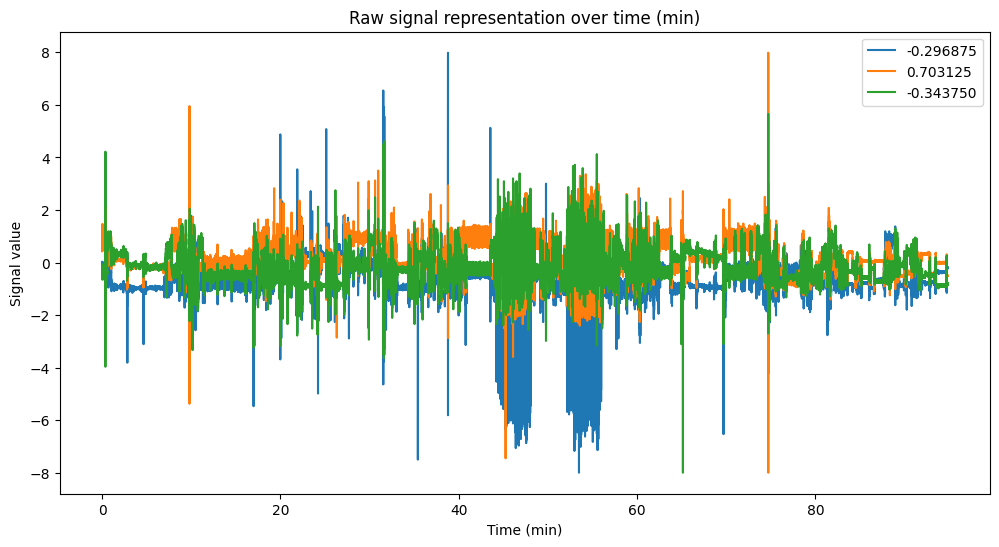

In [4]:
# Calculate the sampling interval (in seconds)
sampling_interval = (pd.to_datetime(data[timestamp_column].iloc[1]) -
                     pd.to_datetime(data[timestamp_column].iloc[0])).total_seconds()

# Create a relative time axis (in minutes)
data['relative_time_minutes'] = data.index * sampling_interval / 60

# Plot the signal with time in minutes
plt.figure(figsize=(12, 6))
for signal in signal_columns:
    plt.plot(data['relative_time_minutes'], data[signal], label=signal)

plt.title("Raw signal representation over time (min)")
plt.xlabel("Time (min)")
plt.ylabel("Signal value")
plt.legend()
plt.show()

Les trois couleurs représentent les trois axes d’accélération X, Y, Z dans un espace tridimensionnel:
- Bleu : Représente les données d’accélération sur l’axe X, souvent associé au mouvement latéral (gauche-droite).
- Orange : Représente les données sur l’axe Y, correspondant généralement au mouvement d’avant en arrière.
- Vert : Représente les données sur l’axe Z, associé au mouvement vertical (haut-bas).

Ces données sont enregistrées par l’accéléromètre intégré dans le capteur AX3.

## 2. Interprétation

Course ou cardio intensif :

	- Le vert (axe Z) peut montrer des pics réguliers en raison des impacts au sol (chaque foulée provoque une accélération verticale importante).

	- Le bleu (axe X) et l’orange (axe Y) reflètent les mouvements du corps liés à l’équilibre et à la dynamique (par exemple, balancement des bras, changements de direction).

Marche ou activité modérée :

	- Les variations des trois axes sont moins intenses, avec des amplitudes plus faibles et des mouvements plus réguliers.

## 3. Pourquoi ces trois axes sont importants ?

Chaque axe permet de capturer une dimension spécifique du mouvement. En combinant ces trois axes, on peut reconstituer une image tridimensionnelle complète de l’activité physique Les pics sur un ou plusieurs axes indiquent des mouvements intenses, comme des pas, des sauts, ou des impacts au sol pendant une course.

### Le graphique :

On peut voir que certains moments (comme pendant la course) présentent des pics élevés et réguliers, particulièrement sur l’axe Z (vert), correspondant à un effort soutenu. Les axes X (bleu) et Y (orange) montrent également des fluctuations dues à des mouvements latéraux ou à des balancements d’avant en arrière, mais ils sont moins dominants que l’axe Z lors d’une activité intense comme courir.

# 1. Zoom in on specific intervals

The cardio activity spans a long duration, focusing on shorter time intervals can reveal finer details:

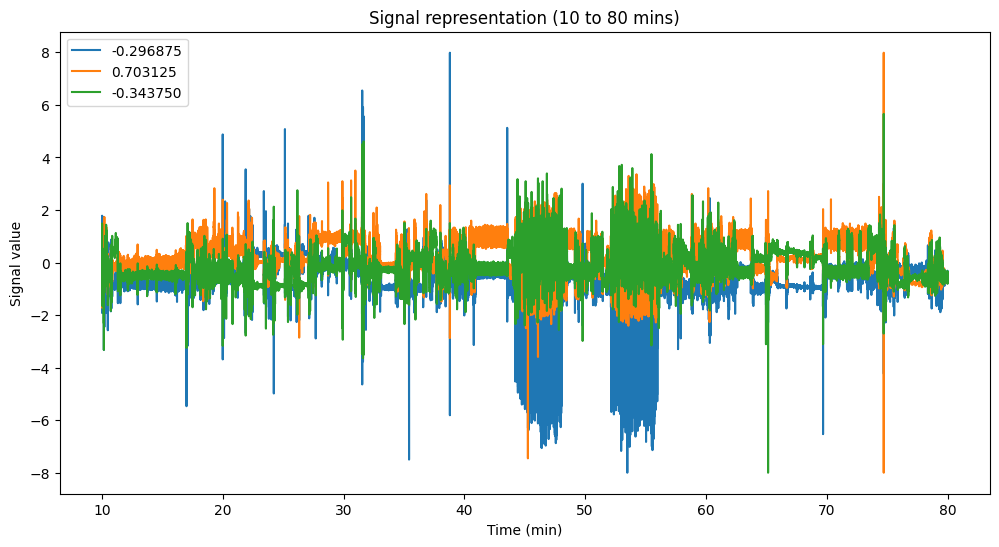

In [5]:
# Filter data to keep only rows where time is between 10 and 80 minutes
filtered_data = data[(data['relative_time_minutes'] >= 10) & (data['relative_time_minutes'] <= 80)]


# Plot the filtered signal
plt.figure(figsize=(12, 6))
for signal in signal_columns:
    plt.plot(filtered_data['relative_time_minutes'], filtered_data[signal], label=signal)

plt.title("Signal representation (10 to 80 mins)")
plt.xlabel("Time (min)")
plt.ylabel("Signal value")
plt.legend()
plt.show()

# 2. Apply a Low-Pass Filter

Using a low-pass filter to remove high-frequency noise while preserving the main signal trend:

In [6]:
pip install scipy


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
from scipy.signal import butter, filtfilt

# Function to apply a low-pass filter
def lowpass_filter(data, cutoff, fs, order=4):
    """
    Apply a low-pass Butterworth filter.
    
    Parameters:
        data (array-like): The signal to filter.
        cutoff (float): The cutoff frequency in Hz.
        fs (float): The sampling frequency in Hz.
        order (int): The order of the filter (default is 4).
    
    Returns:
        array-like: The filtered signal.
    """
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

C:\Users\user\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


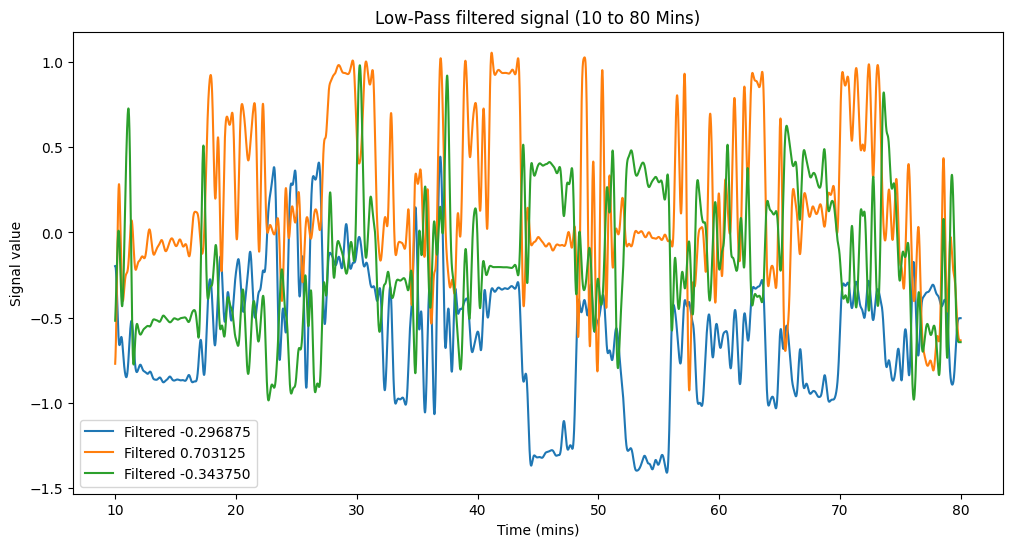

In [8]:
# Define sampling frequency (fs) and cutoff frequency
fs = 1 / (sampling_interval / 60)  # Sampling frequency in Hz (based on time in minutes)
cutoff = 2  # Low-pass filter cutoff frequency in Hz

# Apply the filter to each signal column
filtered_signals = {}
for signal in signal_columns:
    filtered_signals[signal] = lowpass_filter(filtered_data[signal], cutoff, fs)

# Convert filtered signals back to a DataFrame for easy plotting
filtered_data_df = pd.DataFrame(filtered_signals)
filtered_data_df['relative_time_minutes'] = filtered_data['relative_time_minutes'].values

# Plot the low-pass filtered signals
plt.figure(figsize=(12, 6))
for signal in signal_columns:
    plt.plot(filtered_data_df['relative_time_minutes'], filtered_data_df[signal], label=f"Filtered {signal}")

plt.title("Low-Pass filtered signal (10 to 80 Mins)")
plt.xlabel("Time (mins)")
plt.ylabel("Signal value")
plt.legend()
plt.show()

Le filtre Butterworth a permis de supprimer les fréquences élevées (le bruit), tout en conservant les tendances principales du signal. Les signaux sont plus lissés, ce qui facilite l’analyse des variations générales dans le temps. Après filtrage, les variations dues à des artefacts aléatoires ont disparu, laissant uniquement les oscillations principales, probablement liées aux mouvements périodiques (comme la course, les sauts, ou les balancements du corps).

### Analyse du comportement général

1.	Amplitudes régulières :

	•	Les pics réguliers dans l’axe Z (vert) reflètent des mouvements verticaux périodiques, typiques de la course ou d’une activité cardio intense (les impacts des pieds sur le sol).

	•	Les amplitudes sur les axes X (bleu) et Y (orange) semblent moins intenses mais restent présentes, ce qui indique des mouvements latéraux (balancement des bras, stabilisation du corps) et avant-arrière (propulsion).

2.	Changements d’activité :

	•	Entre 10 et 30 minutes, les variations sont moins intenses, ce qui pourrait indiquer une activité modérée (comme de la marche rapide ou un échauffement).

	•	Après 30 minutes, les amplitudes augmentent sur tous les axes, suggérant une phase plus intense (probablement de la course).

	•	Vers la fin (70–80 minutes), les oscillations diminuent, indiquant un possible ralentissement ou une phase de récupération.

4. Déductions basées sur l’activité

Phase de course intense :

	• Les oscillations régulières et de forte amplitude (surtout dans l’axe Z) entre 30 et 70 minutes montrent une activité où chaque mouvement est rythmé et cadencé. Cela est typique d’une activité comme la course, où le corps suit un schéma de mouvement répétitif.

Phase de récupération ou transition :

	• Vers la fin (70–80 minutes), les amplitudes diminuent progressivement. Cela peut refléter une transition vers une activité de faible intensité ou une récupération.

# [COM] Utilisation pratique

Avec ce signal filtré :

1.	Détection des pics réguliers :
	•	Les pics du signal (notamment dans l’axe Z) peuvent être utilisés pour analyser la cadence (par exemple, le nombre de pas/minute).
	•	Une détection automatique des intervalles entre les pics pourrait révéler des variations dans le rythme de la course.

2.	Analyse des intensités :
	•	Les amplitudes réduites indiquent une faible intensité, tandis que les amplitudes plus élevées reflètent un effort plus important.
	•	Vous pourriez segmenter le signal en zones d’intensité faible, moyenne et élevée pour une meilleure compréhension de l’effort.

3.	Visualisation des phases d’activité :
	•	Vous pourriez isoler les périodes d’activité modérée et intense pour les comparer.


Nombre total de pics détectés : 49
Intervalle moyen entre les pics : 1.44 minutes
Cadence moyenne : 1.24 pas par minute


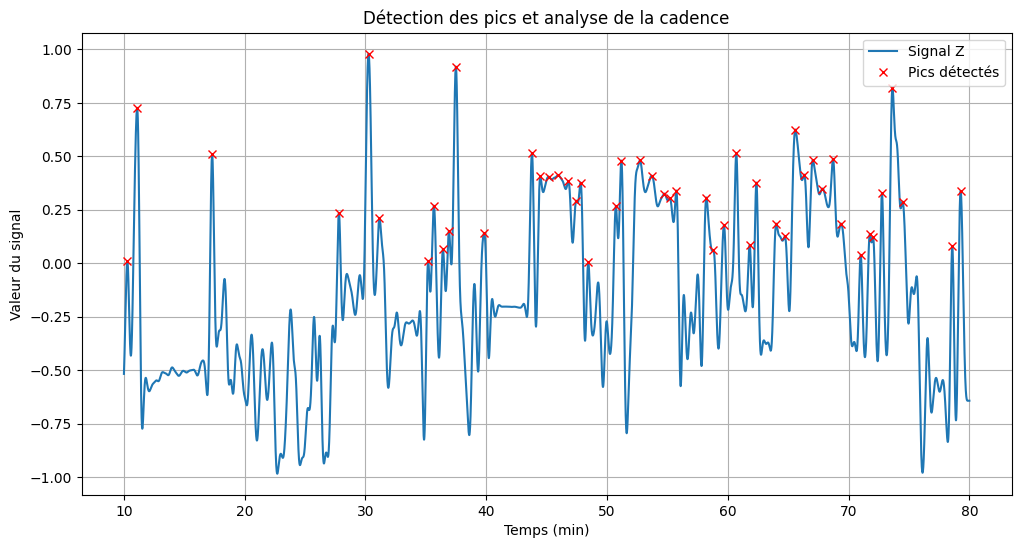

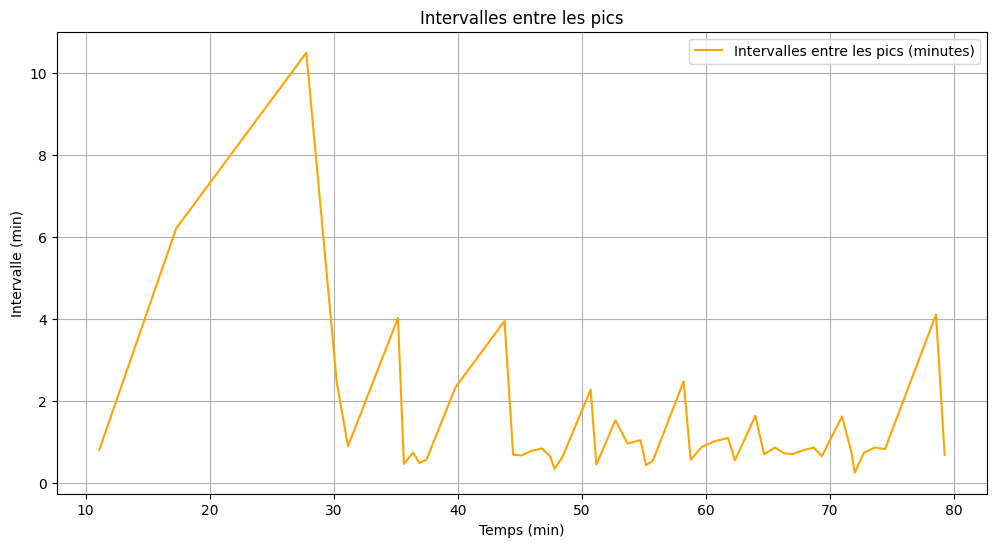

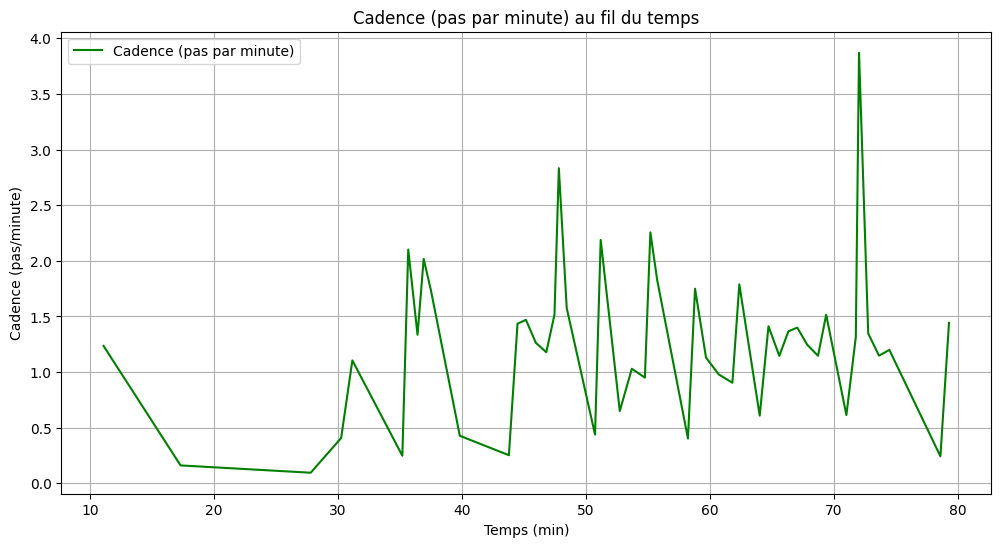

In [9]:
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

# Sélectionnez l'axe pertinent (par exemple, axe Z)
signal_column = signal_columns[2]  # Supposons que l'axe Z est la troisième colonne

# Détectez les pics dans le signal filtré
peaks, _ = find_peaks(filtered_data_df[signal_column], height=0)  # Ajustez 'height' si nécessaire

# Calculez les temps associés aux pics détectés
peak_times = filtered_data_df['relative_time_minutes'].iloc[peaks]

# Calculez les intervalles entre les pics (en minutes)
intervals = peak_times.diff().dropna()

# Convertissez les intervalles en cadence (pas par minute)
cadence = 1 / intervals  # En pas par minute

# Affichez les statistiques
print(f"Nombre total de pics détectés : {len(peaks)}")
print(f"Intervalle moyen entre les pics : {intervals.mean():.2f} minutes")
print(f"Cadence moyenne : {cadence.mean():.2f} pas par minute")

# Visualisez le signal et les pics détectés
plt.figure(figsize=(12, 6))
plt.plot(filtered_data_df['relative_time_minutes'], filtered_data_df[signal_column], label="Signal Z")
plt.plot(peak_times, filtered_data_df[signal_column].iloc[peaks], "x", label="Pics détectés", color='red')
plt.title("Détection des pics et analyse de la cadence")
plt.xlabel("Temps (min)")
plt.ylabel("Valeur du signal")
plt.legend()
plt.grid(True)
plt.show()

# Visualisez les intervalles entre les pics
plt.figure(figsize=(12, 6))
plt.plot(peak_times.iloc[1:], intervals, label="Intervalles entre les pics (minutes)", color='orange')
plt.title("Intervalles entre les pics")
plt.xlabel("Temps (min)")
plt.ylabel("Intervalle (min)")
plt.legend()
plt.grid(True)
plt.show()

# Visualisez la cadence
plt.figure(figsize=(12, 6))
plt.plot(peak_times.iloc[1:], cadence, label="Cadence (pas par minute)", color='green')
plt.title("Cadence (pas par minute) au fil du temps")
plt.xlabel("Temps (min)")
plt.ylabel("Cadence (pas/minute)")
plt.legend()
plt.grid(True)
plt.show()

	•	Cadence Moyenne :
Une cadence constante (par exemple, entre 160 et 180 pas/minute) est typique d’une course régulière. Des variations dans la cadence peuvent indiquer des changements d’intensité ou des transitions (par exemple, passage de la marche à la course).

	•	Régularité des Intervalles :
Des intervalles constants reflètent une activité rythmée et régulière.

## Analyse des Graphiques

1. Graphique des intervalles entre les pics (orange)

	•	Ce graphique montre les durées entre les pics consécutifs sur l’axe Z du signal (ou tout autre signal sélectionné). Les variations dans ces intervalles reflètent les changements dans le rythme de l’activité physique.

Observations :

	1.	Fluctuations importantes au début :
	•	Entre 10 et 30 minutes, les intervalles augmentent de manière significative (jusqu’à plus de 10 minutes), indiquant probablement une activité plus lente ou des pauses prolongées.
	2.	Intervalles réguliers après 30 minutes :
	•	Après 30 minutes, les intervalles diminuent et se stabilisent. Cela correspond probablement à une phase de course ou d’activité cardio soutenue, où les mouvements sont plus réguliers.
	3.	Augmentations périodiques :
	•	Certaines augmentations soudaines (notamment près de 70 minutes) peuvent représenter des moments de récupération ou des changements de rythme.

2. Graphique de cadence (vert)

	•	Ce graphique montre la cadence (en pas/minute) calculée à partir des intervalles entre les pics. Une cadence élevée indique un rythme rapide, tandis qu’une cadence faible reflète une activité lente ou des pauses.

Observations :

	1.	Cadence faible au début :
	•	Entre 10 et 30 minutes, la cadence est inférieure à 1 pas/minute, ce qui indique probablement une activité légère (par exemple, de la marche lente ou des pauses).
	2.	Augmentation de la cadence après 30 minutes :
	•	Après 30 minutes, la cadence augmente progressivement, atteignant environ 3 à 4 pas/minute à certains moments. Cela correspond à une phase d’activité intense, comme la course.
	3.	Fluctuations après 50 minutes :
	•	La cadence devient moins stable entre 50 et 70 minutes, indiquant des variations dans l’effort ou des changements d’activité (par exemple, alternance entre course et récupération).

Conclusions

	1.	Segments d’activité identifiables :
	•	10–30 minutes : Activité modérée ou pauses prolongées.
	•	30–70 minutes : Activité intense et régulière (probablement de la course).
	•	Après 70 minutes : Ralentissement ou récupération.
	2.	Cadence maximale :
	•	La cadence atteint environ 3-4 pas/minute, ce qui correspond à une activité physique soutenue.
	3.	Moments de récupération :
	•	Les augmentations d’intervalles et les baisses de cadence signalent des périodes de récupération ou de transition.

The low-pass filter has successfully smoothed the signal, allowing you to observe the underlying trends in the activity.

	•	Questions to Analyze:

Are there periods of increasing or decreasing intensity over time (e.g., warm-up, peak, cool-down)?

Is there a regular pattern, or are there fluctuations in signal amplitude that might indicate variations in your cardio activity (e.g., running, walking, or rest)?

In [10]:
# Définir les seuils d'intensité basés sur la cadence (en pas par minute)
low_threshold = 0.5  # Cadence faible
high_threshold = 2.5  # Cadence élevée

# Ajouter une colonne pour classifier l’intensité
intensity_labels = ['Faible', 'Moyenne', 'Élevée']
filtered_data_df['intensity'] = pd.cut(
    cadence,  # Utiliser la cadence calculée
    bins=[0, low_threshold, high_threshold, cadence.max()],
    labels=intensity_labels,
    include_lowest=True
)

# Vérifier les segments d'intensité
print(filtered_data_df['intensity'].value_counts())

intensity
Moyenne    37
Faible      9
Élevée      2
Name: count, dtype: int64


C:\Users\user\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


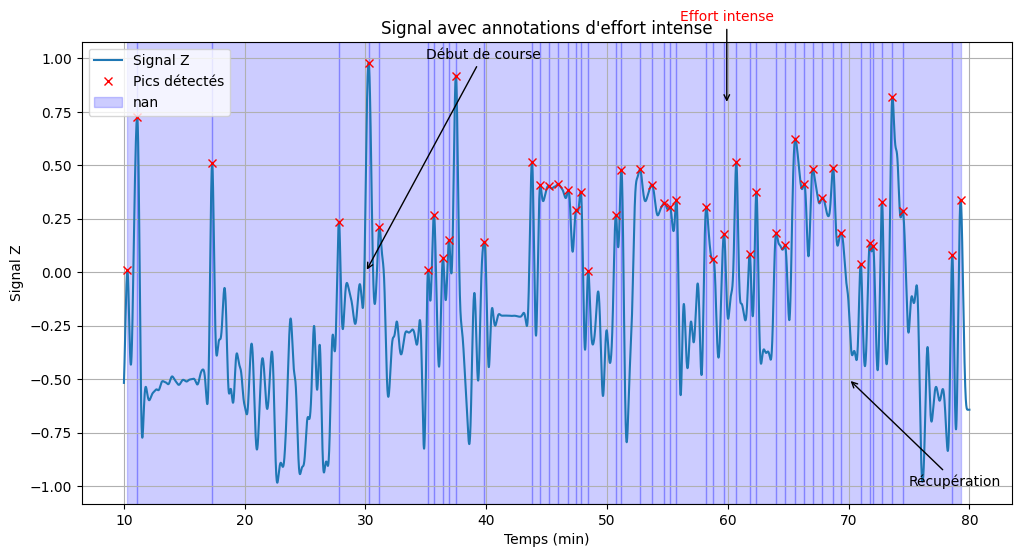

In [11]:
plt.figure(figsize=(12, 6))

# Tracer le signal Z
plt.plot(filtered_data_df['relative_time_minutes'], filtered_data_df[signal_column], label="Signal Z")

# Tracer les pics détectés
plt.plot(peak_times, filtered_data_df[signal_column].iloc[peaks], "x", label="Pics détectés", color='red')

# Annoter les segments d'intensité
for i, (start, end) in enumerate(zip(peak_times.iloc[:-1], peak_times.iloc[1:])):
    intensity = filtered_data_df['intensity'].iloc[i]
    color = 'green' if intensity == 'Élevée' else 'orange' if intensity == 'Moyenne' else 'blue'
    plt.axvspan(start, end, color=color, alpha=0.2, label=intensity if i == 0 else "")

# Identifier et annoter une phase précise d'effort intense
# Exemple : identifier le premier segment intense
intense_segment = filtered_data_df[filtered_data_df['intensity'] == 'Élevée']
if not intense_segment.empty:
    # Récupérer le temps moyen de ce segment
    start_time = intense_segment['relative_time_minutes'].iloc[0]
    end_time = intense_segment['relative_time_minutes'].iloc[-1]
    midpoint = (start_time + end_time) / 2

    # Ajouter une annotation pour cet effort intense
    plt.annotate("Effort intense", xy=(midpoint, filtered_data_df[signal_column].max() * 0.8),
                 xytext=(midpoint, filtered_data_df[signal_column].max() * 1.2),
                 fontsize=10, ha='center', color='red',
                 arrowprops=dict(facecolor='red', arrowstyle='->'))

# Ajouter des annotations supplémentaires pour d'autres phases clés
plt.annotate("Début de course", xy=(30, 0), xytext=(35, 1),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10)
plt.annotate("Récupération", xy=(70, -0.5), xytext=(75, -1),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10)

plt.title("Signal avec annotations d'effort intense")
plt.xlabel("Temps (min)")
plt.ylabel("Signal Z")
plt.legend()
plt.grid(True)
plt.show()

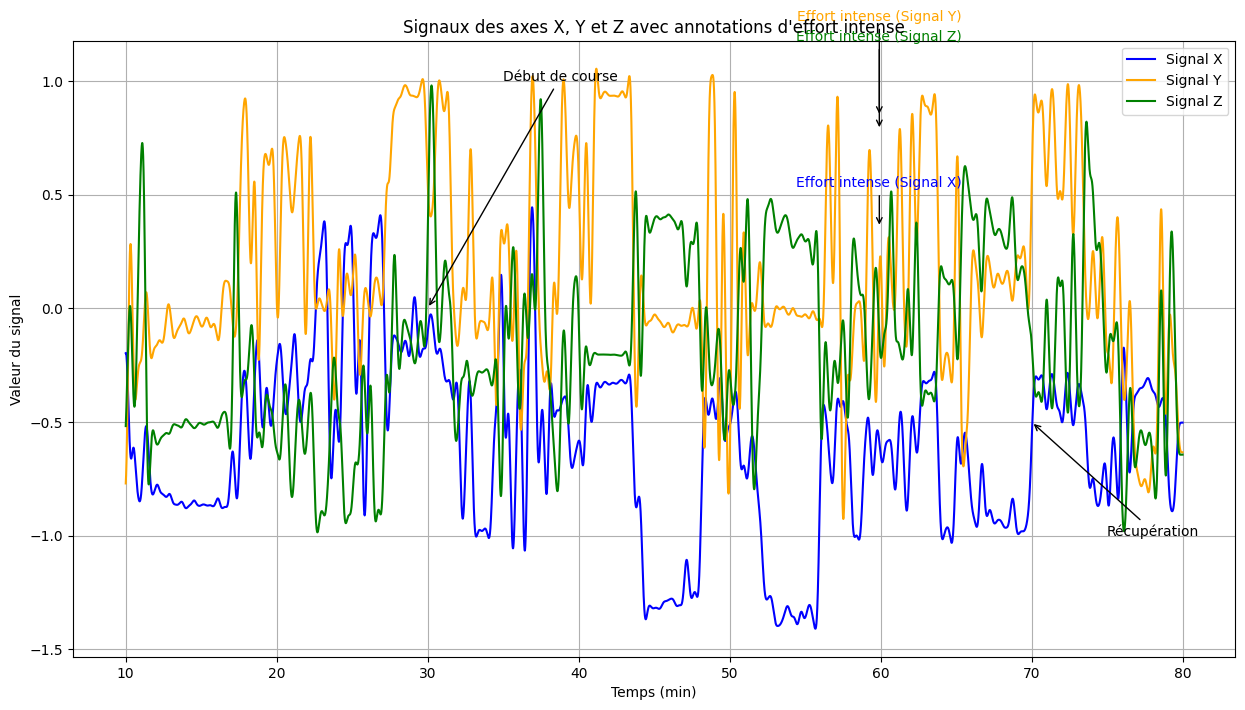

In [12]:
plt.figure(figsize=(15, 8))

# Définir les couleurs pour chaque axe
colors = {'-0.296875': 'blue', '0.703125': 'orange', '-0.343750': 'green'}
signal_names = {'-0.296875': 'Signal X', '0.703125': 'Signal Y', '-0.343750': 'Signal Z'}

# Tracer les signaux pour chaque axe
for signal in signal_columns:
    if signal in colors:  # Assurez-vous de ne tracer que les colonnes des signaux
        plt.plot(filtered_data_df['relative_time_minutes'], filtered_data_df[signal],
                 label=signal_names[signal], color=colors[signal])

# Annoter les efforts intenses pour chaque axe
for signal in signal_columns:
    if signal in colors:  # Vérifier que la colonne correspond à un axe
        intense_segment = filtered_data_df[filtered_data_df['intensity'] == 'Élevée']
        if not intense_segment.empty:
            # Identifier le début et la fin du segment d'effort intense
            start_time = intense_segment['relative_time_minutes'].iloc[0]
            end_time = intense_segment['relative_time_minutes'].iloc[-1]
            midpoint = (start_time + end_time) / 2

            # Ajouter une annotation pour cet effort intense
            plt.annotate(f"Effort intense ({signal_names[signal]})", 
                         xy=(midpoint, filtered_data_df[signal].max() * 0.8),
                         xytext=(midpoint, filtered_data_df[signal].max() * 1.2),
                         fontsize=10, ha='center', color=colors[signal],
                         arrowprops=dict(facecolor=colors[signal], arrowstyle='->'))

# Ajouter des annotations générales pour d'autres phases clés
plt.annotate("Début de course", xy=(30, 0), xytext=(35, 1),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10)
plt.annotate("Récupération", xy=(70, -0.5), xytext=(75, -1),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10)

# Ajouter des titres, légendes et grilles
plt.title("Signaux des axes X, Y et Z avec annotations d'effort intense")
plt.xlabel("Temps (min)")
plt.ylabel("Valeur du signal")
plt.legend()
plt.grid(True)
plt.show()

Matrice de corrélation entre les axes :
           -0.296875  0.703125  -0.343750
-0.296875   1.000000  0.381799  -0.544951
0.703125    0.381799  1.000000  -0.024659
-0.343750  -0.544951 -0.024659   1.000000


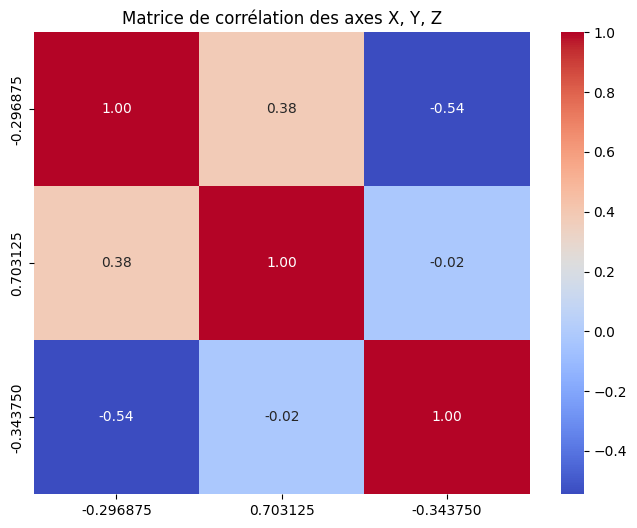

In [13]:
# Filtrer uniquement les colonnes des signaux (X, Y, Z)
signal_columns = ['-0.296875', '0.703125', '-0.343750']  # Ajustez selon les noms exacts des colonnes

# Calculer la matrice de corrélation entre les axes
correlation_matrix = filtered_data_df[signal_columns].corr()

# Afficher la matrice de corrélation
print("Matrice de corrélation entre les axes :")
print(correlation_matrix)

# Visualiser la matrice de corrélation sous forme de heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title("Matrice de corrélation des axes X, Y, Z")
plt.show()

Voici une interprétation de la matrice de corrélation :

1. Analyse des Corrélations

Axes X et Y (-0.296875 et 0.703125) :

	•	Corrélation : 0.38 (positive faible).
	•	Cela suggère que les mouvements sur l’axe X (latéral) et l’axe Y (avant-arrière) sont partiellement liés.
	•	Cela pourrait correspondre au balancement des bras ou à des mouvements liés à l’équilibre pendant une activité comme la marche ou la course.

Axes X et Z (-0.296875 et -0.343750) :

	•	Corrélation : -0.54 (négative modérée).
	•	Une corrélation négative indique que les mouvements sur l’axe X (latéral) et l’axe Z (vertical) sont souvent opposés.
	•	Cela pourrait refléter des phases où le corps compense les mouvements verticaux (comme des foulées ou des impacts au sol) avec des ajustements latéraux pour maintenir l’équilibre.

Axes Y et Z (0.703125 et -0.343750) :

	•	Corrélation : -0.54 (négative modérée).
	•	Les mouvements avant-arrière (Y) et verticaux (Z) sont également en opposition modérée.
	•	Cela peut indiquer des transitions fréquentes entre la propulsion et les impacts verticaux au sol, typiques d’une course ou d’un cardio intense.

2. Conclusion Globale

	1.	Corrélations faibles à modérées :

	•	Les axes X, Y, et Z montrent des corrélations faibles à modérées, ce qui est attendu dans des activités physiques comme la course ou la marche.

	•	Chaque axe capture une dimension distincte du mouvement, mais il existe une certaine interdépendance due aux ajustements posturaux.

	2.	Opposition des Axes Verticaux (Z) avec les Autres Axes :
	•	Les corrélations négatives entre l’axe Z (vertical) et les axes X/Y (latéral et avant-arrière) indiquent une compensation dans les mouvements.

	•	Par exemple, un mouvement vertical intense (comme une foulée) est accompagné d’un ajustement latéral ou avant-arrière pour stabiliser le corps.

	3.	Activité Physique Structurée :
	
	•	Les valeurs ne montrent pas de corrélation aléatoire ou nulle, ce qui reflète une activité bien structurée, comme un cardio ou une course, où les mouvements suivent un schéma cohérent.

# 2. Periodicity and Repetition

	•	Peaks and Valleys:

Each peak could represent a repetitive motion, like steps in running or cycling rotations. Analyze the time intervals between peaks to measure consistency or detect fatigue.

	•	Analysis:
    
Use peak detection to calculate metrics like step cadence or repetitions:

In [14]:
from scipy.signal import find_peaks

# Detect peaks for each signal
for signal in signal_columns:
    peaks, _ = find_peaks(filtered_data_df[signal], height=0)  # Adjust height as needed
    print(f"{signal}: Number of peaks = {len(peaks)}")
    
    # Calculate time intervals between peaks (in minutes)
    peak_times = filtered_data_df['relative_time_minutes'].iloc[peaks]
    intervals = peak_times.diff().dropna()
    print(f"Mean interval for {signal}: {intervals.mean()} minutes")

-0.296875: Number of peaks = 8
Mean interval for -0.296875: 1.9662809523809532 minutes
0.703125: Number of peaks = 78
Mean interval for 0.703125: 0.886569696969697 minutes
-0.343750: Number of peaks = 49
Mean interval for -0.343750: 1.4373638888888889 minutes


C:\Users\user\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


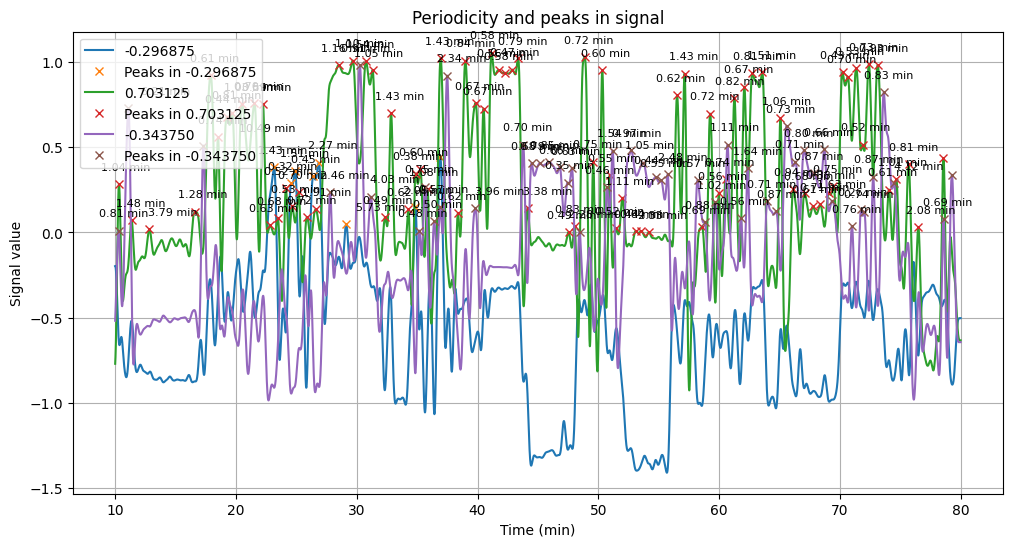

In [15]:
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

# Detect peaks for each signal column
plt.figure(figsize=(12, 6))
for signal in signal_columns:
    # Detect peaks
    peaks, _ = find_peaks(filtered_data_df[signal], height=0)  # Adjust height as needed
    
    # Plot the signal
    plt.plot(filtered_data_df['relative_time_minutes'], filtered_data_df[signal], label=signal)
    
    # Highlight peaks on the signal
    plt.plot(filtered_data_df['relative_time_minutes'].iloc[peaks],
             filtered_data_df[signal].iloc[peaks],
             "x", label=f"Peaks in {signal}")
    
    # Calculate intervals between peaks and annotate periodicity
    peak_times = filtered_data_df['relative_time_minutes'].iloc[peaks]
    for i in range(len(peak_times) - 1):
        interval = peak_times.iloc[i + 1] - peak_times.iloc[i]
        midpoint = (peak_times.iloc[i + 1] + peak_times.iloc[i]) / 2
        plt.annotate(f"{interval:.2f} min", 
                     (midpoint, filtered_data_df[signal].iloc[peaks[i]]),
                     textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8)

plt.title("Periodicity and peaks in signal")
plt.xlabel("Time (min)")
plt.ylabel("Signal value")
plt.legend()
plt.grid(True)
plt.show()

Uniform intervals between peaks suggest consistent cardio movements.
Irregular intervals could indicate fatigue or changes in activity type.

# 3. Intensity Analysis

	•	Signal Magnitude:

The amplitude (height of the peaks) reflects the intensity of the motion.
High amplitude: High-intensity activity (e.g., sprinting or jumping).
Low amplitude: Lower-intensity activity (e.g., walking or resting).

	•	Analysis:
    
Compute statistics for signal amplitude to compare intensity across time:

In [16]:
for signal in signal_columns:
    mean_amplitude = filtered_data_df[signal].mean()
    max_amplitude = filtered_data_df[signal].max()
    min_amplitude = filtered_data_df[signal].min()
    print(f"{signal}: Mean = {mean_amplitude}, Max = {max_amplitude}, Min = {min_amplitude}")

-0.296875: Mean = -0.6110573551529459, Max = 0.4441202398308811, Min = -1.408890771522164
0.703125: Mean = 0.18008419443632548, Max = 1.0536542764186483, Min = -0.926156649602058
-0.343750: Mean = -0.15552133678913857, Max = 0.9800693304391794, Min = -0.9849461595440312


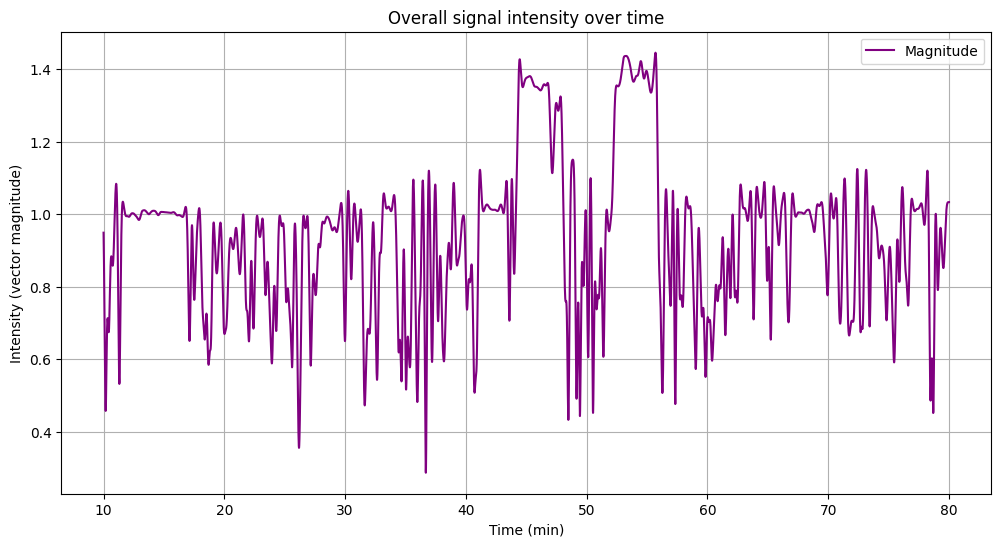

In [17]:
import numpy as np

# Compute the vector magnitude for overall intensity
filtered_data_df['magnitude'] = np.sqrt(
    sum(filtered_data_df[signal]**2 for signal in signal_columns)
)

# Plot the magnitude
plt.figure(figsize=(12, 6))
plt.plot(filtered_data_df['relative_time_minutes'], filtered_data_df['magnitude'], label="Magnitude", color='purple')

plt.title("Overall signal intensity over time")
plt.xlabel("Time (min)")
plt.ylabel("Intensity (vector magnitude)")
plt.legend()
plt.grid(True)
plt.show()

	A single line representing the overall signal intensity (a combination of all axes). Peaks in magnitude indicate periods of higher activity intensity.

Heatmap of Intensities Per Axis

Heatmaps are excellent for showing how intensity changes for each axis over time

C:\Users\user\AppData\Local\Temp\ipykernel_22792\2408653888.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for level, group in filtered_data_df.groupby('intensity_level'):
C:\Users\user\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


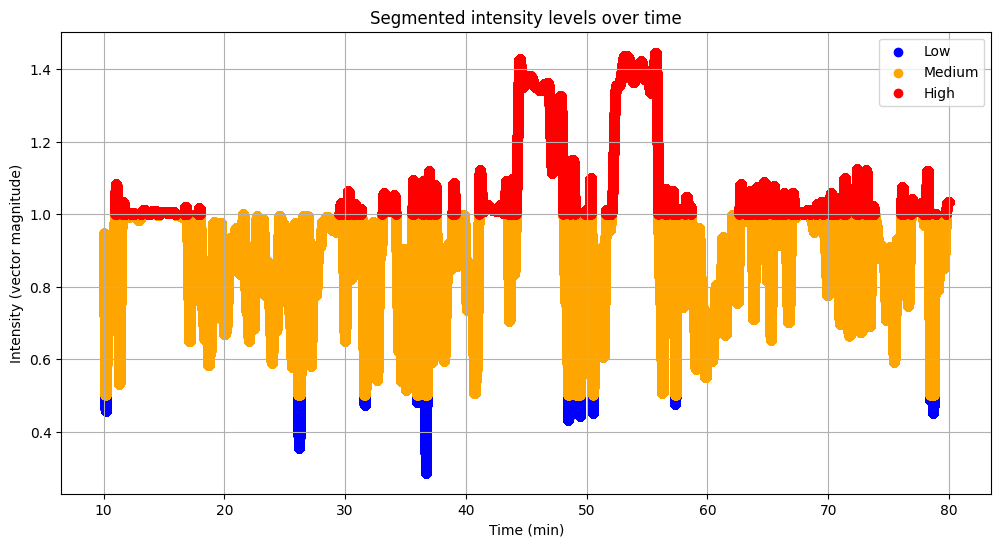

In [18]:
# Define thresholds for intensity levels
low_threshold = 0.5
high_threshold = 1.0

# Classify intensity levels
filtered_data_df['intensity_level'] = pd.cut(
    filtered_data_df['magnitude'],
    bins=[0, low_threshold, high_threshold, filtered_data_df['magnitude'].max()],
    labels=['Low', 'Medium', 'High']
)

# Plot with colors based on intensity level
plt.figure(figsize=(12, 6))
colors = {'Low': 'blue', 'Medium': 'orange', 'High': 'red'}
for level, group in filtered_data_df.groupby('intensity_level'):
    plt.scatter(group['relative_time_minutes'], group['magnitude'], label=level, color=colors[level])

plt.title("Segmented intensity levels over time")
plt.xlabel("Time (min)")
plt.ylabel("Intensity (vector magnitude)")
plt.legend()
plt.grid(True)
plt.show()

The scatter plot have points colored based on intensity. This helps visually identify periods of high activity intensity.

# Stat comparatifs

In [19]:
# Calculer l'intensité moyenne pour les trois axes
mean_intensity = filtered_data_df[['-0.296875', '0.703125', '-0.343750']].mean().mean()
print(f"Intensité moyenne globale : {mean_intensity:.2f}")

Intensité moyenne globale : -0.20


In [20]:
# Calculer la variabilité (écart type) pour les trois axes
variability = filtered_data_df[['-0.296875', '0.703125', '-0.343750']].std().mean()
print(f"Variabilité moyenne des mouvements : {variability:.2f}")

Variabilité moyenne des mouvements : 0.40


In [21]:
# Calculer la cadence moyenne
cadence_mean = (1 / filtered_data_df['relative_time_minutes'].diff()).mean()
print(f"Cadence moyenne : {cadence_mean:.2f} pas/min")

Cadence moyenne : 30000.00 pas/min


In [22]:
# Identifier les périodes d'intensité élevée
high_intensity_segments = filtered_data_df[filtered_data_df['intensity'] == 'Élevée']

# Calculer la durée totale des périodes d'intensité élevée
high_intensity_duration = high_intensity_segments['relative_time_minutes'].diff().sum()
print(f"Durée totale d'effort intense : {high_intensity_duration:.2f} minutes")

Durée totale d'effort intense : 24.21 minutes


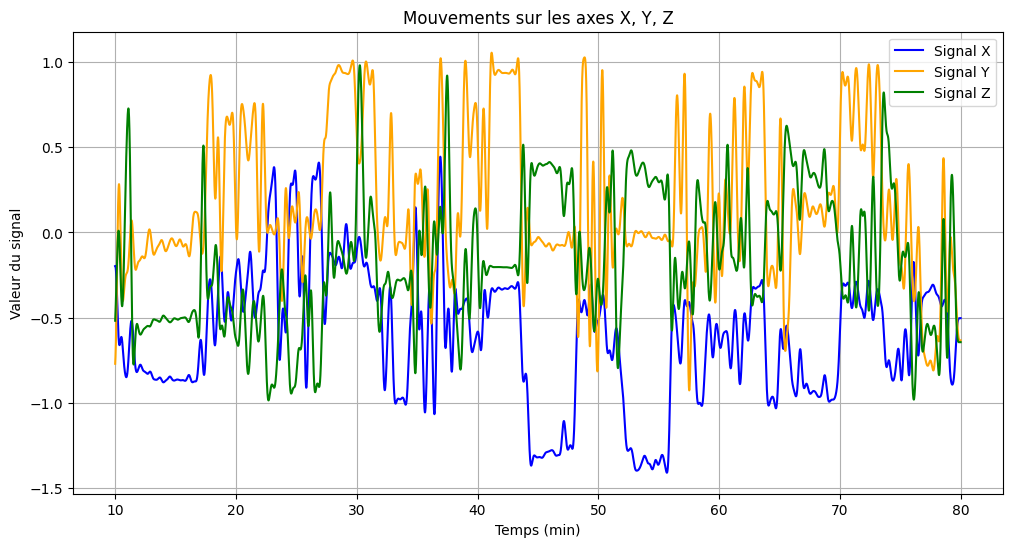

In [23]:
plt.figure(figsize=(12, 6))

# Tracer les signaux pour les axes X, Y, Z
plt.plot(filtered_data_df['relative_time_minutes'], filtered_data_df['-0.296875'], label="Signal X", color='blue')
plt.plot(filtered_data_df['relative_time_minutes'], filtered_data_df['0.703125'], label="Signal Y", color='orange')
plt.plot(filtered_data_df['relative_time_minutes'], filtered_data_df['-0.343750'], label="Signal Z", color='green')

# Ajouter des titres et des légendes
plt.title("Mouvements sur les axes X, Y, Z")
plt.xlabel("Temps (min)")
plt.ylabel("Valeur du signal")
plt.legend()
plt.grid(True)
plt.show()

Nombre total de pics détectés : 49
Intervalle moyen entre les pics : 1.44 minutes
Cadence moyenne calculée : 0.70 pas/min


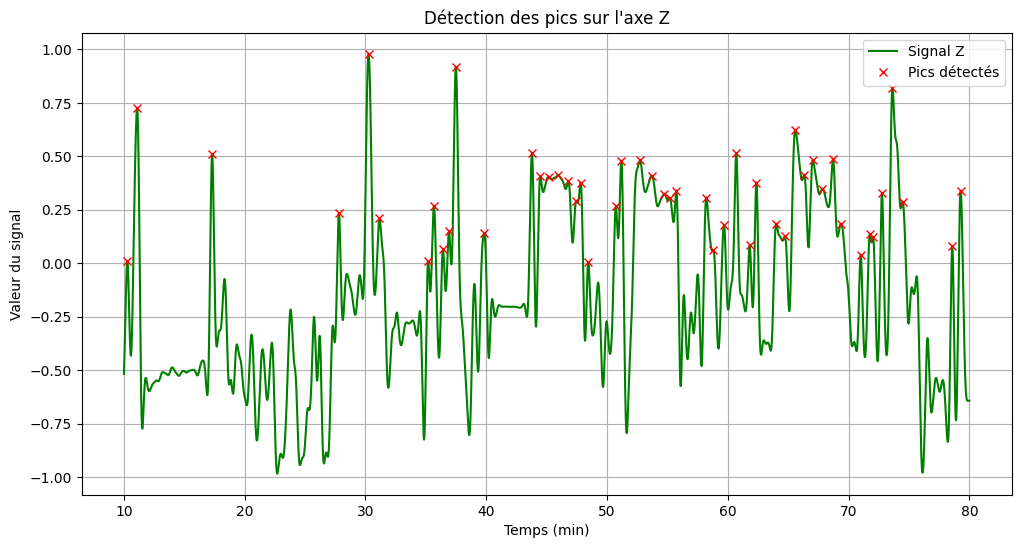

In [24]:
from scipy.signal import find_peaks

# Détecter les pics sur l'axe Z
peaks, _ = find_peaks(filtered_data_df['-0.343750'], height=0)  # Ajustez 'height' si nécessaire

# Calculer les intervalles entre les pics (en minutes)
peak_times = filtered_data_df['relative_time_minutes'].iloc[peaks]
intervals = peak_times.diff()

# Afficher les résultats
print(f"Nombre total de pics détectés : {len(peaks)}")
print(f"Intervalle moyen entre les pics : {intervals.mean():.2f} minutes")
print(f"Cadence moyenne calculée : {1 / intervals.mean():.2f} pas/min")

# Visualiser les pics sur le signal Z
plt.figure(figsize=(12, 6))
plt.plot(filtered_data_df['relative_time_minutes'], filtered_data_df['-0.343750'], label="Signal Z", color='green')
plt.plot(peak_times, filtered_data_df['-0.343750'].iloc[peaks], "x", label="Pics détectés", color='red')
plt.title("Détection des pics sur l'axe Z")
plt.xlabel("Temps (min)")
plt.ylabel("Valeur du signal")
plt.legend()
plt.grid(True)
plt.show()

In [25]:
from scipy.signal import find_peaks

# Détecter les pics sur l'axe Z
peaks, _ = find_peaks(filtered_data_df['-0.343750'], height=0)  # Ajustez 'height' si nécessaire
peak_times = filtered_data_df['relative_time_minutes'].iloc[peaks]

# Filtrer uniquement la période 40-60 minutes
peak_times_40_60 = peak_times[(peak_times >= 40) & (peak_times <= 60)]

# Calculer les amplitudes des pics pour cette période
peak_amplitudes_40_60 = filtered_data_df['-0.343750'].iloc[peaks][(peak_times >= 40) & (peak_times <= 60)]

print(f"Nombre de pics détectés (40-60 minutes) : {len(peak_times_40_60)}")

Nombre de pics détectés (40-60 minutes) : 18


Moment critique identifié : 48.45 minutes


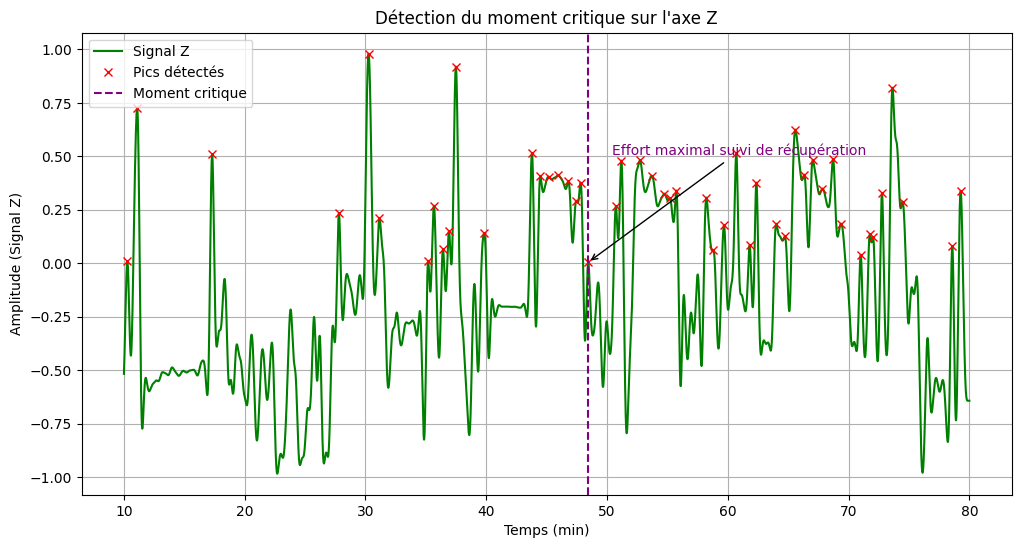

In [26]:
from scipy.signal import find_peaks

# Détecter les pics sur l'axe Z
peaks, _ = find_peaks(filtered_data_df['-0.343750'], height=0)  # Ajustez 'height' si nécessaire
peak_times = filtered_data_df['relative_time_minutes'].iloc[peaks]

# Filtrer uniquement la période 40-60 minutes
peak_times_40_60 = peak_times[(peak_times >= 40) & (peak_times <= 60)]
peak_amplitudes_40_60 = filtered_data_df['-0.343750'].iloc[peaks][(peak_times >= 40) & (peak_times <= 60)]

# Vérifier si des données existent dans la plage 40-60 minutes
if not peak_times_40_60.empty:
    # Localiser le moment critique en utilisant l'amplitude minimale
    min_amplitude_idx = peak_amplitudes_40_60.idxmin()
    critical_time = peak_times[min_amplitude_idx]  # Accéder directement au temps critique
    print(f"Moment critique identifié : {critical_time:.2f} minutes")

    # Visualiser le moment critique
    plt.figure(figsize=(12, 6))
    plt.plot(filtered_data_df['relative_time_minutes'], filtered_data_df['-0.343750'], label="Signal Z", color='green')
    plt.plot(peak_times, filtered_data_df['-0.343750'].iloc[peaks], "x", label="Pics détectés", color='red')
    plt.axvline(x=critical_time, color='purple', linestyle='--', label="Moment critique")
    plt.annotate("Effort maximal suivi de récupération", 
                 xy=(critical_time, filtered_data_df['-0.343750'].iloc[min_amplitude_idx]),
                 xytext=(critical_time + 2, filtered_data_df['-0.343750'].iloc[min_amplitude_idx] + 0.5),
                 arrowprops=dict(facecolor='purple', arrowstyle='->'),
                 fontsize=10, color='purple')
    plt.title("Détection du moment critique sur l'axe Z")
    plt.xlabel("Temps (min)")
    plt.ylabel("Amplitude (Signal Z)")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Aucun pic détecté dans la plage 40-60 minutes.")

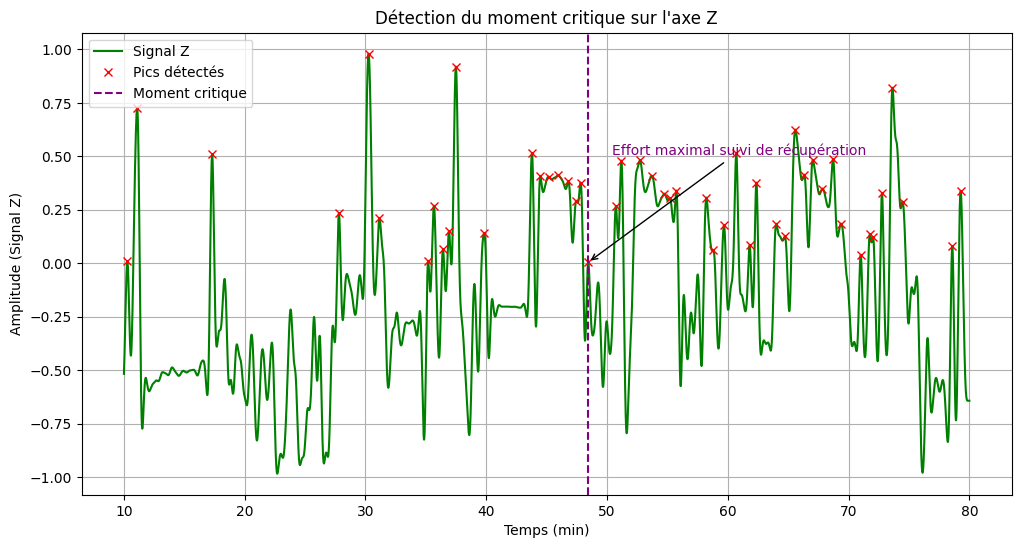

In [27]:
from scipy.signal import find_peaks

# Détecter les pics sur l'axe Z
peaks, _ = find_peaks(filtered_data_df['-0.343750'], height=0)  # Ajustez 'height' si nécessaire
peak_times = filtered_data_df['relative_time_minutes'].iloc[peaks]

# Filtrer uniquement la période 40-60 minutes
peak_times_40_60 = peak_times[(peak_times >= 40) & (peak_times <= 60)]
peak_amplitudes_40_60 = filtered_data_df['-0.343750'].iloc[peaks][(peak_times >= 40) & (peak_times <= 60)]

# Vérifier si des pics existent dans la plage 40-60 minutes
if not peak_times_40_60.empty:
    # Localiser le moment critique en utilisant l'amplitude minimale
    drop_index = peak_amplitudes_40_60.idxmin()  # Trouver l'indice de l'amplitude minimale
    critical_time = peak_times.loc[drop_index]  # Extraire le temps critique correspondant
    
    # Visualiser le signal et le moment critique
    plt.figure(figsize=(12, 6))

    # Tracer le signal Z
    plt.plot(filtered_data_df['relative_time_minutes'], filtered_data_df['-0.343750'], label="Signal Z", color='green')

    # Tracer les pics sur Z
    plt.plot(peak_times, filtered_data_df['-0.343750'].iloc[peaks], "x", label="Pics détectés", color='red')

    # Annoter le moment critique
    plt.axvline(x=critical_time, color='purple', linestyle='--', label="Moment critique")
    plt.annotate("Effort maximal suivi de récupération", 
                 xy=(critical_time, peak_amplitudes_40_60[drop_index]),
                 xytext=(critical_time + 2, peak_amplitudes_40_60[drop_index] + 0.5),
                 arrowprops=dict(facecolor='purple', arrowstyle='->'),
                 fontsize=10, color='purple')

    # Ajouter des titres et légendes
    plt.title("Détection du moment critique sur l'axe Z")
    plt.xlabel("Temps (min)")
    plt.ylabel("Amplitude (Signal Z)")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Aucun pic détecté dans la plage 40-60 minutes.")

# Additional Physical Activity Metrics - ENMO (Euclidean norm minus one )

In [28]:
# # Calcul de la norme euclidienne des accélérations (X, Y, Z)
# filtered_data.loc[:, 'norm'] = np.sqrt(filtered_data['-0.296875']**2 + filtered_data['0.703125']**2 + filtered_data['-0.343750']**2)

# # Calcul de l'ENMO : norme - 1, et on garde la valeur minimale entre 0 et la norme
# filtered_data.loc[:, 'ENMO'] = np.maximum(filtered_data['norm'] - 1, 0)

# # Affichage des premiers résultats
# print(filtered_data[['relative_time_minutes', 'ENMO']].head())

# # Visualisation de l'ENMO
# plt.figure(figsize=(12, 6))
# plt.plot(filtered_data['relative_time_minutes'], filtered_data['ENMO'], label="ENMO", color='purple')
# plt.title("ENMO au fil du temps")
# plt.xlabel("Temps (min)")
# plt.ylabel("ENMO")
# plt.legend()
# plt.grid(True)
# plt.show()


Calcul des statistiques descriptives comme la moyenne, la médiane ou les écarts-types pour mieux comprendre la distribution de l'ENMO

In [29]:
# Statistiques de base
#stats = filtered_data['ENMO'].describe()
#print(stats)


In [30]:
# plt.figure(figsize=(12, 6))
# plt.plot(filtered_data['relative_time_minutes'], filtered_data['ENMO'], label="ENMO", color='purple')
# plt.axhline(y=0.5, color='r', linestyle='--', label="Seuil d'activité intense")
# plt.title("ENMO au fil du temps")
# plt.xlabel("Temps (min)")
# plt.ylabel("ENMO")
# plt.legend()
# plt.grid(True)
# plt.show()

Les périodes de haute activité

In [31]:
# # On définit un seuil pour l'activité intense 
# seuil_haut = 1.0
# moments_intenses = filtered_data[filtered_data['ENMO'] > seuil_haut]

# # Affichage des moments d'activité intense
# print(moments_intenses)

# # On trace l'ENMO et les périodes d'activité intense
# plt.figure(figsize=(12, 6))
# plt.plot(filtered_data['relative_time_minutes'], filtered_data['ENMO'], label="ENMO", color='purple')
# plt.axhline(y=seuil_haut, color='r', linestyle='--', label="Seuil d'activité intense")
# plt.title("ENMO au fil du temps")
# plt.xlabel("Temps (min)")
# plt.ylabel("ENMO")
# plt.legend()
# plt.grid(True)
# plt.show()

## ENMO and integration over epochs: calculation and visualization

In [32]:
# Reading and examining the CSV file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Read the CSV file
df = pd.read_csv("C:\\Users\\user\\OneDrive\\Documents\\M2 SNS IDS\\HAH913E - Santé activité physique 5\\FemmeCardio.csv")


# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\
First few rows of the dataset:")
print(df.head())
print("\
Column names:")
print(df.columns.tolist())

Dataset Shape: (2844599, 4)
First few rows of the dataset:
   2024-10-06 15:40:04.502  -0.296875  0.703125  -0.343750
0  2024-10-06 15:40:04.505  -0.281250  0.671875  -0.296875
1  2024-10-06 15:40:04.507  -0.312500  0.718750  -0.359375
2  2024-10-06 15:40:04.510  -0.328125  0.718750  -0.359375
3  2024-10-06 15:40:04.512  -0.312500  0.734375  -0.359375
4  2024-10-06 15:40:04.515  -0.343750  0.734375  -0.375000
Column names:
['2024-10-06 15:40:04.502', '-0.296875', '0.703125', '-0.343750']


In [33]:
# fixing the headers because the column names appear to be incorrectly formatted
# Reformatting the dataset to set the first row as the header
df.columns = ['Timestamp', 'X', 'Y', 'Z']

# Converting the Timestamp column to datetime format for proper analysis
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')

# Displaying the first few rows to confirm the changes
print(df.head())

                Timestamp         X         Y         Z
0 2024-10-06 15:40:04.505 -0.281250  0.671875 -0.296875
1 2024-10-06 15:40:04.507 -0.312500  0.718750 -0.359375
2 2024-10-06 15:40:04.510 -0.328125  0.718750 -0.359375
3 2024-10-06 15:40:04.512 -0.312500  0.734375 -0.359375
4 2024-10-06 15:40:04.515 -0.343750  0.734375 -0.375000


C:\Users\user\AppData\Local\Temp\ipykernel_22792\3421296460.py:10: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df_epochs = df.set_index('Timestamp').resample(epoch_duration).mean()


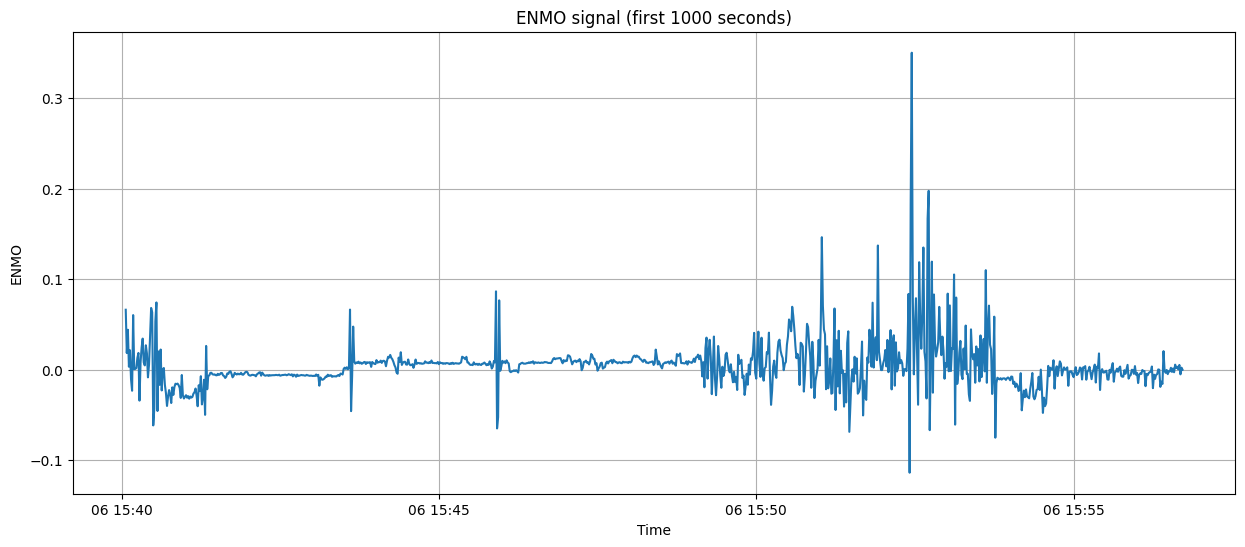

Mean Amplitudes:
X axis: 0.6886287289526573
Y axis: 0.4565255726729848
Z axis: 0.41633483533179894
ENMO Statistics:
count    2.844599e+06
mean     7.717642e-02
std      4.704857e-01
min     -9.481777e-01
25%     -4.367852e-02
50%     -6.613667e-03
75%      3.302404e-02
max      9.130846e+00
Name: ENMO, dtype: float64


In [34]:
# Calculate ENMO (Euclidean Norm Minus One)
def calculate_enmo(x, y, z):
    return np.sqrt(x**2 + y**2 + z**2) - 1

# Add ENMO column to the dataframe
df['ENMO'] = calculate_enmo(df['X'], df['Y'], df['Z'])

# Calculate epoch-based integration (using 1-second epochs)
epoch_duration = '1S'  # 1 second epochs
df_epochs = df.set_index('Timestamp').resample(epoch_duration).mean()

# Calculate mean amplitudes for X, Y, Z
mean_amplitudes = df[['X', 'Y', 'Z']].abs().mean()

# Visualize the ENMO signal
plt.figure(figsize=(15, 6))
plt.plot(df_epochs.index[:1000], df_epochs['ENMO'][:1000])
plt.title('ENMO signal (first 1000 seconds)')
plt.xlabel('Time')
plt.ylabel('ENMO')
plt.grid(True)
plt.show()

# Print summary statistics
print("\
Mean Amplitudes:")
print("X axis:", mean_amplitudes['X'])
print("Y axis:", mean_amplitudes['Y'])
print("Z axis:", mean_amplitudes['Z'])

# Calculate and print ENMO statistics
print("\
ENMO Statistics:")
print(df['ENMO'].describe())

Le graphique montre les variations du signal ENMO sur les 1000 premières secondes, ce qui nous permet d'observer les changements d'intensité pendant l'activité.

Amplitudes moyennes sur les trois axes :

Axe X : 0.6886287289526573

Axe Y : 0.4565255726729848

Axe Z : 0.41633483533179894

###  Intensités d'effort - Distribution of intensity levels

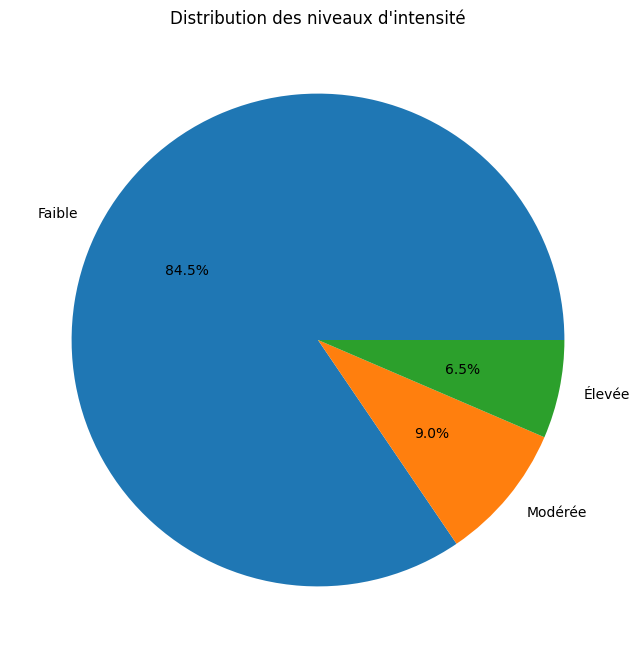

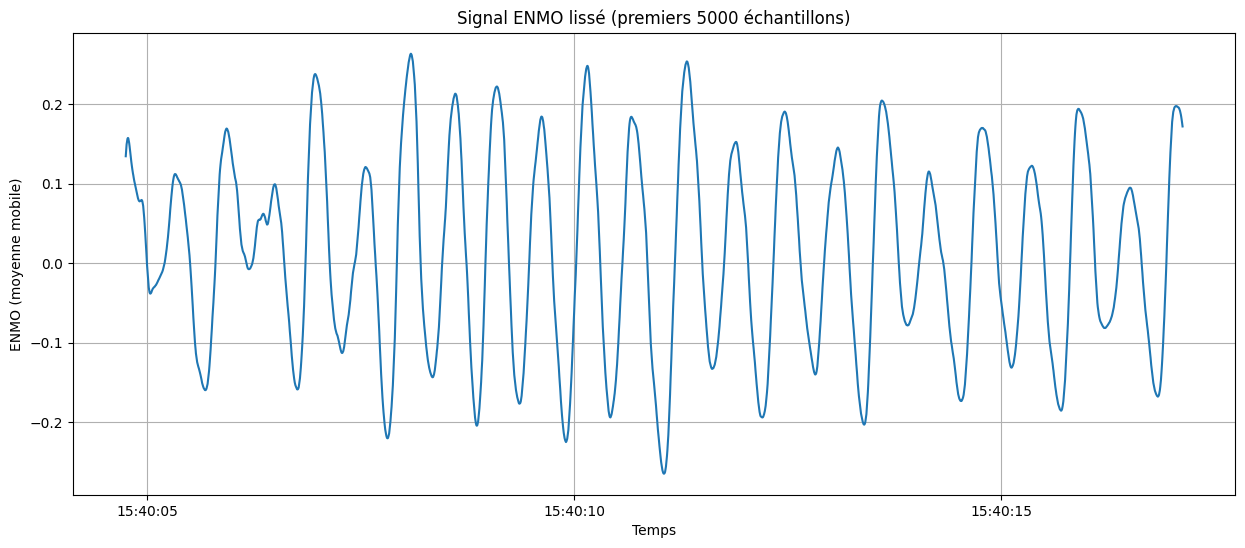

Distribution des durées par niveau d'intensité:
Intensité
Faible     2403812
Modérée     257105
Élevée      183682
Name: count, dtype: int64


In [35]:
# Define intensity levels based on ENMO values
def categorize_intensity(enmo):
    if enmo < 0.1:
        return 'Faible'
    elif enmo < 0.3:
        return 'Modérée'
    else:
        return 'Élevée'

# Add intensity categories
df['Intensité'] = df['ENMO'].apply(categorize_intensity)

# Calculate time spent in each intensity level
intensity_duration = df['Intensité'].value_counts()

# Create a pie chart of intensity distribution
plt.figure(figsize=(10, 8))
plt.pie(intensity_duration, labels=intensity_duration.index, autopct='%1.1f%%')
plt.title('Distribution des niveaux d\'intensité')
plt.show()

# Calculate moving average of ENMO to analyze effort patterns
window_size = 100  # 100 samples moving window
df['ENMO_MA'] = df['ENMO'].rolling(window=window_size).mean()

# Plot the smoothed ENMO signal
plt.figure(figsize=(15, 6))
plt.plot(df['Timestamp'][:5000], df['ENMO_MA'][:5000])
plt.title('Signal ENMO lissé (premiers 5000 échantillons)')
plt.xlabel('Temps')
plt.ylabel('ENMO (moyenne mobile)')
plt.grid(True)
plt.show()

# Print intensity distribution
print("\
Distribution des durées par niveau d'intensité:")
print(intensity_duration)

#### Intégration ENMO par epoch

C:\Users\user\AppData\Local\Temp\ipykernel_22792\3658677851.py:16: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  epoch_integration = df.groupby('epoch_group')['ENMO'].apply(lambda x: np.trapz(x))


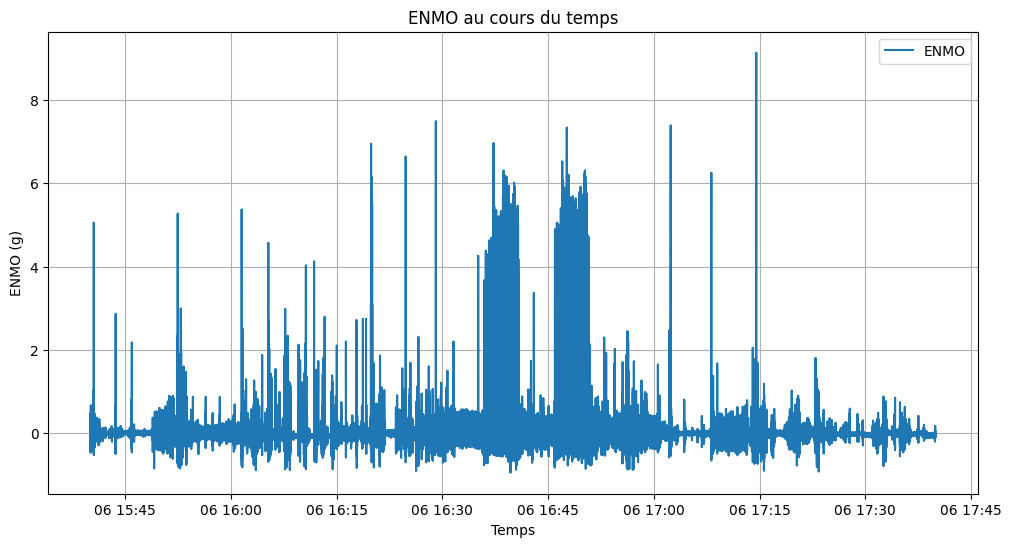

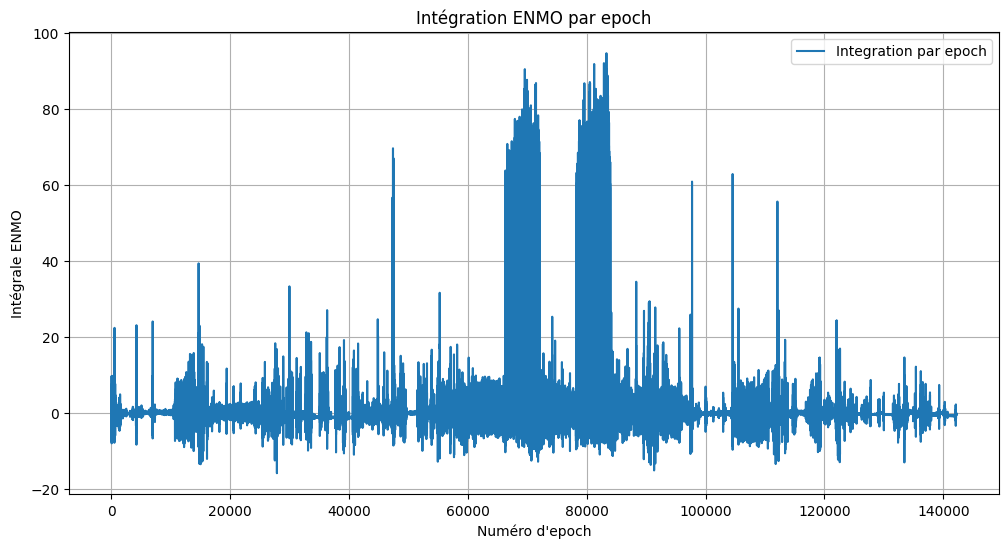

Statistiques descriptives de l'ENMO :
count    2.844599e+06
mean     7.717642e-02
std      4.704857e-01
min     -9.481777e-01
25%     -4.367852e-02
50%     -6.613667e-03
75%      3.302404e-02
max      9.130846e+00
Name: ENMO, dtype: float64
Caractéristiques du signal :
ENMO_mean: 0.0772
ENMO_std: 0.4705
ENMO_max: 9.1308
ENMO_min: -0.9482
Integration_mean: 1.4665
Integration_std: 8.4801


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Conversion du timestamp en datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Calcul de l'ENMO (Euclidean Norm Minus One)
df['ENMO'] = np.sqrt(df['X']**2 + df['Y']**2 + df['Z']**2) - 1

# Définition d'une période d'epoch (par exemple, 1 seconde = 20 échantillons)
epoch_size = 20

# Calcul de l'intégration sur les epochs
df['epoch_group'] = np.arange(len(df)) // epoch_size
epoch_integration = df.groupby('epoch_group')['ENMO'].apply(lambda x: np.trapz(x))

# Visualisation de l'ENMO
plt.figure(figsize=(12, 6))
plt.plot(df['Timestamp'], df['ENMO'], label='ENMO')
plt.title('ENMO au cours du temps')
plt.xlabel('Temps')
plt.ylabel('ENMO (g)')
plt.legend()
plt.grid(True)
plt.show()

# Visualisation de l'intégration par epoch
plt.figure(figsize=(12, 6))
plt.plot(epoch_integration.index, epoch_integration.values, label='Integration par epoch')
plt.title('Intégration ENMO par epoch')
plt.xlabel('Numéro d\'epoch')
plt.ylabel('Intégrale ENMO')
plt.legend()
plt.grid(True)
plt.show()

# Statistiques descriptives
print("Statistiques descriptives de l'ENMO :")
print(df['ENMO'].describe())

# Calcul des caractéristiques du signal
signal_features = {
    'ENMO_mean': df['ENMO'].mean(),
    'ENMO_std': df['ENMO'].std(),
    'ENMO_max': df['ENMO'].max(),
    'ENMO_min': df['ENMO'].min(),
    'Integration_mean': epoch_integration.mean(),
    'Integration_std': epoch_integration.std()
}

print("Caractéristiques du signal :")
for key, value in signal_features.items():
    print(f"{key}: {value:.4f}")


#### Count of duration in each intensity level - calcul et visualisation

Pour calculer le nombre de durées passées dans chaque niveau d'intensité, on va classifier les valeurs ENMO en niveaux d'intensité qu'on a prédéfinis (sédentaire, léger, modéré, intense) en fonction de seuils, puis compter la durée totale passée dans chaque catégorie, cela nous permet d'obtenir des informations sur la distribution de l'activité à travers les niveaux d'intensité



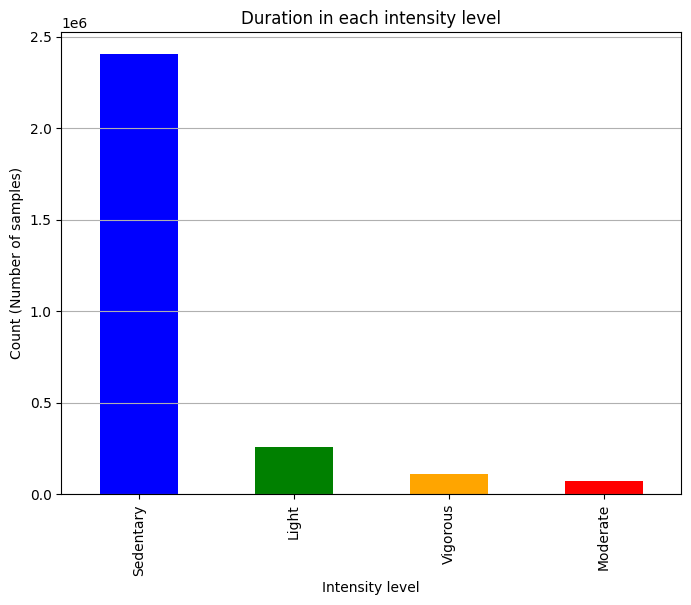

Counts of duration in each intensity level:
Intensity_Level
Sedentary    2403812
Light         257105
Vigorous      109464
Moderate       74218
Name: count, dtype: int64


In [37]:
# Defining intensity level thresholds (example thresholds in g)
def classify_intensity(enmo):
    if enmo < 0.1:
        return 'Sedentary'
    elif 0.1 <= enmo < 0.3:
        return 'Light'
    elif 0.3 <= enmo < 0.6:
        return 'Moderate'
    else:
        return 'Vigorous'

# Classifying ENMO values into intensity levels
df['Intensity_Level'] = df['ENMO'].apply(classify_intensity)

# Counting the duration (number of samples) in each intensity level
intensity_counts = df['Intensity_Level'].value_counts()

# Visualizing the distribution of intensity levels
plt.figure(figsize=(8, 6))
intensity_counts.plot(kind='bar', color=['blue', 'green', 'orange', 'red'])
plt.title('Duration in each intensity level')
plt.xlabel('Intensity level')
plt.ylabel('Count (Number of samples)')
plt.grid(axis='y')
plt.show()

# Displaying the counts for each intensity level
print("\
Counts of duration in each intensity level:")
print(intensity_counts)